# Numerical Optimization and Large Scale Linear Algebra
## Assignment 4 - PageRank Algorithm
### Instructor: P. Vassalos

**Student:** Phevos A. Margonis - f3352317

**Date:** 14/MAR/2024

---
This exercise aims to study different approaches for computing the PageRank Algorithm as described in the paper: `Langville, A. N., & Meyer, C. D. (2004, October 20). Deeper Inside PageRank. N. Carolina State University. http://www.math.ncsu.edu`. Additionally, the effect of the malicious practice of *Link Farms* is examined.

In [1]:
from time import time,sleep
sleep(0.1)
import numpy as np
import pandas as pd
import scipy.sparse as sp
from tqdm import tqdm
import matplotlib.pyplot as plt
sleep(0.1)
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Constants and Data
alpha = 0.85
tau = 1e-8

# Read the .dat file
data = np.loadtxt("stanweb.dat")
rows = data[:, 0].astype(int)
cols = data[:, 1].astype(int)
probabilities = data[:, 2]
P = sp.csr_matrix((probabilities, (rows, cols)))

print(P)
sleep(0.1) # Debug loading of P
del data, rows, cols, probabilities

  (1, 6548)	0.5
  (1, 15409)	0.5
  (2, 17794)	0.032258064516129
  (2, 25202)	0.032258064516129
  (2, 53625)	0.032258064516129
  (2, 54582)	0.032258064516129
  (2, 64930)	0.032258064516129
  (2, 73764)	0.032258064516129
  (2, 84477)	0.032258064516129
  (2, 98628)	0.032258064516129
  (2, 100193)	0.032258064516129
  (2, 102355)	0.032258064516129
  (2, 105318)	0.032258064516129
  (2, 105730)	0.032258064516129
  (2, 115926)	0.032258064516129
  (2, 140864)	0.032258064516129
  (2, 163550)	0.032258064516129
  (2, 164599)	0.032258064516129
  (2, 175799)	0.032258064516129
  (2, 178642)	0.032258064516129
  (2, 181714)	0.032258064516129
  (2, 190453)	0.032258064516129
  (2, 204189)	0.032258064516129
  (2, 204604)	0.032258064516129
  (2, 210870)	0.032258064516129
  :	:
  (281898, 166893)	0.142857142857143
  (281898, 191219)	0.142857142857143
  (281898, 231579)	0.142857142857143
  (281898, 266496)	0.142857142857143
  (281898, 275195)	0.142857142857143
  (281899, 30564)	0.333333333333333
  (281899, 2

In [3]:
# Functions
def power_method(P, alpha=0.85, tau=1e-8):
    """A 1 Power Method"""
    n = P.shape[0]
    pi = np.ones(n) / n  # Initial PageRank vector
    vT = np.ones(n) / n  # Uniform teleportation vector
    dangling_nodes = np.array(P.sum(axis=1)).squeeze() == 0

    progress_bar = tqdm()
    pi_history = [pi.copy()]  # Track history of pi vectors
    iterations = 0
    while True:
        iterations += 1
        pi_new = alpha * pi @ P + (alpha * pi @ dangling_nodes + (1 - alpha)) * vT # main function

        # Check for convergence
        if np.linalg.norm(pi_new - pi, ord=1) < tau:
            break

        pi = pi_new # prepare for next cycle
        pi_history.append(pi.copy())  # Keep history of pi
        # Update progress bar
        progress_bar.update(1)


    # Close progress bar
    progress_bar.close()
    pi_history = np.array(pi_history)
    pi_error_history = np.abs(pi_history - pi_history[-1])


    return pi, pi_error_history


def linear_system(P, alpha=0.85, tau=1e-8):
    """A2 Linear system"""
    n = P.shape[0]
    dangling_nodes = np.array(P.sum(axis=1)).squeeze() == 0
    nd_indices = np.where(~dangling_nodes)[0]  # Non-dangling indices
    d_indices = np.where(dangling_nodes)[0]  # Dangling indices
    # Partition the matrix as shown in the paper (Algorithm 1)
    P11 = P[nd_indices][:, nd_indices]
    P12 = P[nd_indices][:, d_indices]
    n1 = P11.shape[0]
    vT = np.ones(n) / n  # Uniform teleportation vector
    v1 = vT[nd_indices]
    v2 = vT[d_indices]

    # Step 1: Solve for πT1 in πT1 (I - αP11) = vT1.
    Identity = sp.eye(n1)
    A = Identity - alpha * P11
    pi1, _ = sp.linalg.lgmres( A, v1, atol=tau)  
    # Step 2: Compute πT2 = απT1 P12 + vT2.
    pi2 = alpha * pi1 @ P12 + v2

    # Reconstruct pi following the proper node order
    pi = np.zeros(n)
    pi[nd_indices] = pi1
    pi[d_indices] = pi2

    # Step 3: Normalize πT = [πT1 πT2]/||[πT1 πT2]||1.
    pi /= np.linalg.norm(pi, 1)

    return pi

In [6]:
# A
# A1
start = time()
pi_vector, pi_error_history = power_method(P, alpha, tau)  # Compute the PageRank vector
end = time()
runtime_power_1 = end - start
power_ranking_old = np.argsort(pi_vector)[::-1]
pi_error_history = pi_error_history[:, power_ranking_old]

df = pd.DataFrame(pi_vector).sort_values(0, ascending=False)
df = df.rename_axis('Node').rename(columns={0:'Ranking'})
print('Power Method results')
print("\n", df.head())

# A2
start = time()
pi_linear = linear_system(P, alpha, tau) # Compute the PageRank vector
end = time()
runtime_linear_1 = end - start

df2 = pd.DataFrame(pi_linear).sort_values(0, ascending=False)
df2 = df2.rename_axis('Node').rename(columns={0:'Ranking'})
print("Liniear System Method")
print("\n", df2.head())

90it [00:01, 45.88it/s]


Power Method results

          Ranking
Node            
89073   0.011303
226411  0.009288
241454  0.008297
262860  0.003023
134832  0.003001
Liniear System Method

          Ranking
Node            
235000  0.000004
69931   0.000004
188358  0.000004
272927  0.000004
85415   0.000004


The above print-out proves that the two methods (Power and Linear) converge into different solutions. Between the two, the Linear method is comparatively instantaneous. Additionally, the Gauss-Seidel method has been tested for the computation of the Power method. The Gauss-Seidel method updates each value of $\pi$ sequentially, using the updated $\pi$ vector in each iteration. The paper `[7] Arvind Arasu, Jasmine Novak, Andrew Tomkins, and John Tomlin. PageRank computation and the structure of the Web: experiments and algorithms.  In The Eleventh International WWW Conference, New York, May 2002. ACM Press.` proves that this method should converge faster than the simple approach followed above, but the aforementioned tests proved otherwise. Clearly there was a design flaw in my approach.

In [7]:
# B
start = time()
pi_vector_new, _ = power_method(P, 0.99, tau)  # Compute the PageRank vector
end = time()
runtime_power_2 = end - start
power_ranking_old = np.argsort(pi_vector)[::-1][:50]
power_ranking_new = np.argsort(pi_vector_new)[::-1][:50]
print(f"Are the top 50 elements the same in the two Power Methods?: {set(power_ranking_old)==set(power_ranking_new)}")
print(f"Are they in the same order?: {np.array_equal(power_ranking_old, power_ranking_new)}")
print(f"The process was slower by: {runtime_power_2- runtime_power_1:.3f}sec\n")

start = time()
pi_linear_new = linear_system(P, 0.99, tau)
end = time()
runtime_linear_2 = end - start
linear_ranking_old = np.argsort(pi_linear)[::-1][:50]
linear_ranking_new = np.argsort(pi_linear_new)[::-1][:50]
print(f"Are the top 50 elements the same in the two Linear System Methods?: {set(linear_ranking_old)==set(linear_ranking_new)}")
print(f"Are they in the same order?: {np.array_equal(power_ranking_old, power_ranking_new)}")
print(f"The process was slower by: {runtime_linear_2- runtime_linear_1:.3f}sec\n")

1391it [00:27, 49.74it/s]


Are the top 50 elements the same in the two Power Methods?: False
Are they in the same order?: False
The process was slower by: 30.778sec

Are the top 50 elements the same in the two Linear System Methods?: False
Are they in the same order?: False
The process was slower by: 3.123sec



The above experiment proves that the linear system method is almost 10 times faster than the simple Power method. This makes the use of large `alpha` values, or computation through 'Power Method', prohibitive.

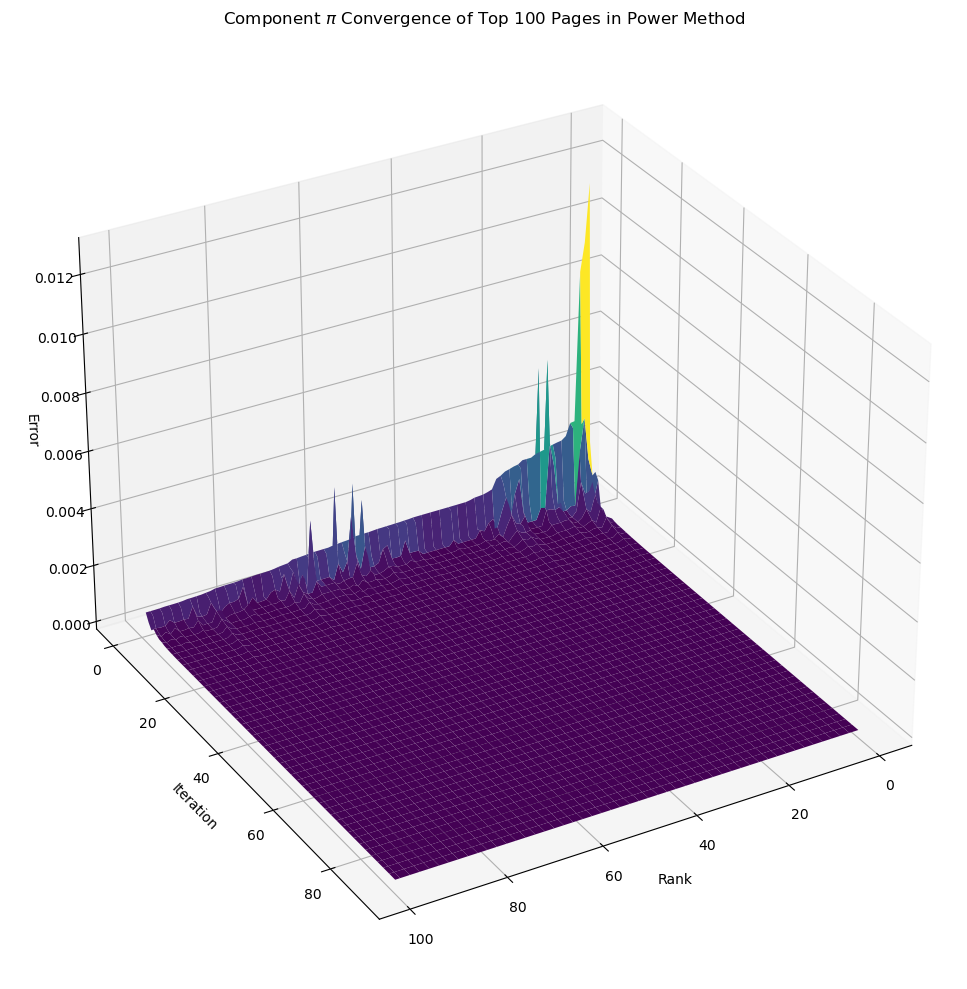

In [14]:
# C
matrix = pi_error_history[:,:100]

# Generate meshgrid for x and y
x, y = np.meshgrid(np.arange(matrix.shape[1]), np.arange(matrix.shape[0]))
# Plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, matrix, cmap='viridis')
ax.set_xlabel('Rank')
ax.set_ylabel('Iteration')
ax.set_zlabel('Error')

# Rotate the plot
ax.view_init(elev=30, azim=60)
plt.title("Component $\pi$ Convergence of Top 100 Pages in Power Method")
plt.tight_layout()
plt.show()

The above plot suggests that the important nodes converge slower.

## Part 2 - Link Farm
---

In this section we create artificial nodes to test how the PageRank algorithm responds to malicious practices that try to boost the rank of a page (in this case page X).

In [15]:
# LINKFARM ====================================================================================================
ranksX = {}
n = P.shape[0]  # Current size of P
nodeX = n

new_row = sp.csr_matrix((1, n)) # Create an empty sparce Row
new_col = sp.csr_matrix((n + 1, 1))  # Create an emptpy sparce Column
P_extended = sp.vstack([P, new_row])
P_extended = sp.hstack([P_extended, new_col]) # Extend P by adding the new row and column
# Solve
pi = linear_system(P_extended, alpha, tau)
# Rankings
piSorted = np.argsort(pi)[::-1]
ranksX['solo'] = np.where(piSorted == nodeX)[0][0]

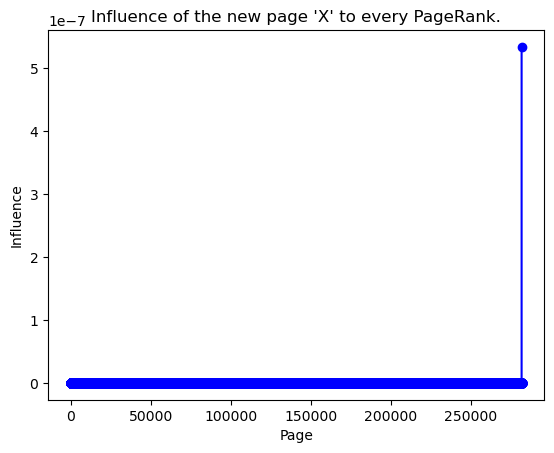

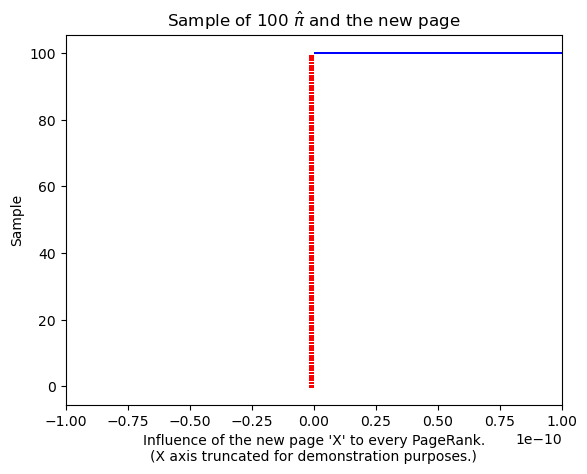

In [20]:
# Visualise influence of adding a dangling node
influence = pi - np.append(pi_linear,0)
# Create the line plot
plt.figure()
values = influence
indices = np.arange(len(values))
plt.plot(indices, values, marker='o', color='blue', linestyle='-')
plt.title("Influence of the new page 'X' to every PageRank.")
plt.xlabel('Page')
plt.ylabel('Influence')
plt.show()

# Create the bar chart
plt.figure()
values = np.random.choice(influence, 100, replace=False)
values = np.append(values,influence[-1])
indices = np.arange(len(values))
plt.barh(indices, values, color=['red' if v < 0 else 'blue' for v in values])
plt.xlim(-1e-10, 1e-10)
plt.title("Sample of 100 $\hat{\pi}$ and the new page")
plt.xlabel("Influence of the new page 'X' to every PageRank.\n(X axis truncated for demonstration purposes.)")
plt.ylabel('Sample')
plt.show()

The above graphs show that the addition of a new 'dangling' page X 'steals' an insignificant amount of ranking from the rest.

In [21]:
# Adding node Y -> X
n = P_extended.shape[0]
new_row = sp.lil_matrix((1, n))
new_row[0, -1] = 1
new_row = new_row.tocsr()
new_col = sp.csr_matrix((n + 1, 1))  # +1 to account for the new node itself
P_extended = sp.vstack([P_extended, new_row])
P_extended = sp.hstack([P_extended, new_col]) # Extend P by adding the new row and column

# Calculate new pi
pi = linear_system(P_extended, alpha, tau) # Calculate new ranikings
piSorted = np.argsort(pi)[::-1] # Sort Nodes based on their Rankings in Descending order
ranksX['Y->X'] = np.where(piSorted == nodeX)[0][0] # Find the index(rank) of the X node
piRankY = np.where(piSorted == nodeX+1)[0][0]

In [22]:
# Add Z -> Y
n = P_extended.shape[0]
new_row = sp.lil_matrix((1, n))
new_row[0, -1] = 1 # -1 points to Y
new_row = new_row.tocsr()
new_col = sp.csr_matrix((n + 1, 1))  # +1 to account for the new node itself
P_extended = sp.vstack([P_extended, new_row])
P_extended = sp.hstack([P_extended, new_col])
# Calculate new pi
pi = linear_system(P_extended, alpha, tau) # Calculate new ranikings
piSorted = np.argsort(pi)[::-1] # Sort Nodes based on their Rankings in Descending order
ranksX['Z->Y->X'] = np.where(piSorted == nodeX)[0][0] # Find the index(rank) of the X node

In [23]:
# Y->X<-Z
n = P_extended.shape[0]
P_extended = P_extended.tolil()
new_row = sp.lil_matrix((1, n))
new_row[0,-3] = 1 # -3 points to X
P_extended[-1,:] = new_row
P_extended = P_extended.tocsr()
# Calculate new pi
pi = linear_system(P_extended, alpha, tau) # Calculate new ranikings
piSorted = np.argsort(pi)[::-1] # Sort Nodes based on their Rankings in Descending order
ranksX['Y->X<-Z'] = np.where(piSorted == nodeX)[0][0] # Find the index(rank) of the X node

In [24]:
# X -> outlinks to TOP
n = P_extended.shape[0]
P_extended_2 = P_extended.tolil()
new_row = sp.lil_matrix((1, n))
Noutlinks = 10
new_row[0,piSorted[:Noutlinks]] = 1/Noutlinks
P_extended_2[-3,:] = new_row # Change X row
P_extended_2 = P_extended_2.tocsr()
# Calculate new pi
pi = linear_system(P_extended_2, alpha, tau) # Calculate new ranikings
piSorted = np.argsort(pi)[::-1] # Sort Nodes based on their Rankings in Descending order
ranksX['Y->X<-Z+X->Top10'] = np.where(piSorted == nodeX)[0][0] # Find the index(rank) of the X node

In [25]:
# Z->TOP
n = P_extended.shape[0]
P_extended_2 = P_extended.tolil()
new_row = sp.lil_matrix((1, n))
Noutlinks = 10
new_row[0,piSorted[:Noutlinks]] = 1/Noutlinks
P_extended_2[-1,:] = new_row # Change Z row
P_extended_2 = P_extended_2.tocsr()
# Calculate new pi
pi = linear_system(P_extended_2, alpha, tau) # Calculate new ranikings
piSorted = np.argsort(pi)[::-1] # Sort Nodes based on their Rankings in Descending order
ranksX['Y->X<-Z+Z->Top10'] = np.where(piSorted == nodeX)[0][0] # Find the index(rank) of the X node

In [30]:
# Results
print(f"(baseline)           The Rank of X is:          {ranksX['solo']}")
print(f"(Y->X)               The new Rank of X is:      {ranksX['Y->X']}")
print(f"The Rank of Y is:                               {piRankY}, which is {piRankY - ranksX['Y->X']} places below X")
print("\nCompared to (baseline):")
print(f"(Y->X)               The Rank of X improved by: {ranksX['solo'] - ranksX['Y->X']}")
print(f"(Z->Y->X)            The Rank of X improved by: {ranksX['solo'] - ranksX['Z->Y->X']} ")
print(f"(Y->X<-Z)            The Rank of X improved by: {ranksX['solo'] - ranksX['Y->X<-Z']} ")
print(f"(Y->X<-Z and X->TOP) The Rank of X improved by: {ranksX['solo'] - ranksX['Y->X<-Z+X->Top10']} ")
print(f"(Y->X<-Z and Z->TOP) The Rank of X improved by: {ranksX['solo'] - ranksX['Y->X<-Z+Z->Top10']} ")

(baseline)           The Rank of X is:          281903
(Y->X)               The new Rank of X is:      281735
The Rank of Y is:                               281822, which is 87 places below X

Compared to (baseline):
(Y->X)               The Rank of X improved by: 168
(Z->Y->X)            The Rank of X improved by: 168 
(Y->X<-Z)            The Rank of X improved by: 358 
(Y->X<-Z and X->TOP) The Rank of X improved by: 664 
(Y->X<-Z and Z->TOP) The Rank of X improved by: 172 


### Results
1. Page X has no in-link nor out-links and surprisingly is above other pages in rank.
2. The node Y was added that points (links) to X. This raised page X by 168 places compared to the baseline.
3. The node Z was added that points to Y. This *chain* scheme did not improve the ranking of X.
4. Now the node Z was pointed exclusively to X. When both Y and Z point to X, its ranking is more than doubled.
5. Out-links where added from X to the top 10 pages of the web. This scheme almost doubled the rank gained for page X.
6. Removing the Out-links from X, and adding Out-links from Z to the top 10, had a negative effect on the rank of page X. This could also explain  the result of (1).

### Conclusions
Combining the above findings, the best strategy to boost the ranking of your page is:
1. Create a set of pages where each page links ONLY to page X. Hence the phrase *Link Farm*.
2. Add links to page X that point to other very popular pages.